In [1]:

from email.mime.text import MIMEText
import smtplib, ssl
from smtplib import SMTP   
from email.mime.multipart import MIMEMultipart # sending email
from email.mime.text import MIMEText  # constructing messages
from jinja2 import Environment        # Jinja2 templating\

import numpy as np
import afinn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyhive import hive
import datetime
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [2]:

stock_lists = {'aapl':'APPLE, Inc.',
                   'msft':'Microsoft Corporation',
                   'amzn':'Amazon.com, Inc.',
                   'baba':'Alibaba Group Holding Limited',
                   'fb':'Facebook, Inc.'
                   ,
                   'googl':'Alphabet Inc.',
                   'jnj':'Johnson & Johnson',
                   'wmt':'Walmart Inc. ',
                   'v':'Visa Inc.',
                   'ma':'Mastercard Incorporated'}
selectedcol = ['pubdate','title','url','summary','score','host']+list(stock_lists.keys())

def newcount_graph():
    ttt = 'select substr(pubdate, 0,8) as dt, count(*) as qty from nutch_ext group by substr(pubdate, 0,8)'
    conn = hive.Connection(host ='daou-bd-r01a01', port = 10000)
    cursor = conn.cursor()
    cursor.execute(ttt)
    countnuews = cursor.fetchall()

    df = pd.DataFrame(countnuews, columns=['date', 'qty'])
    dailyqty= df.sort_values(['date'],ascending=True)[-30:]
    dailyqty['date'] = [a[4:6]+'/'+a[6:8] for a in dailyqty['date']]
    dailyqty = dailyqty[-5:]
    plt.figure(figsize=(14,10))

    plt.figure(figsize=(14,10))

    ax = sns.barplot(x="date", y="qty", data=dailyqty)
    plt.title('Daily Colleted News',fontsize=20,color='#c62f2d')

    for bar in ax.patches:
        bar.set_color('#e5ac9d')
    for p in ax.patches:
             ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=15, color='slategrey', xytext=(0, 10),
                 textcoords='offset points')
    plt.savefig('dailynewscount.png', bbox_inches='tight')






<Figure size 1008x720 with 0 Axes>

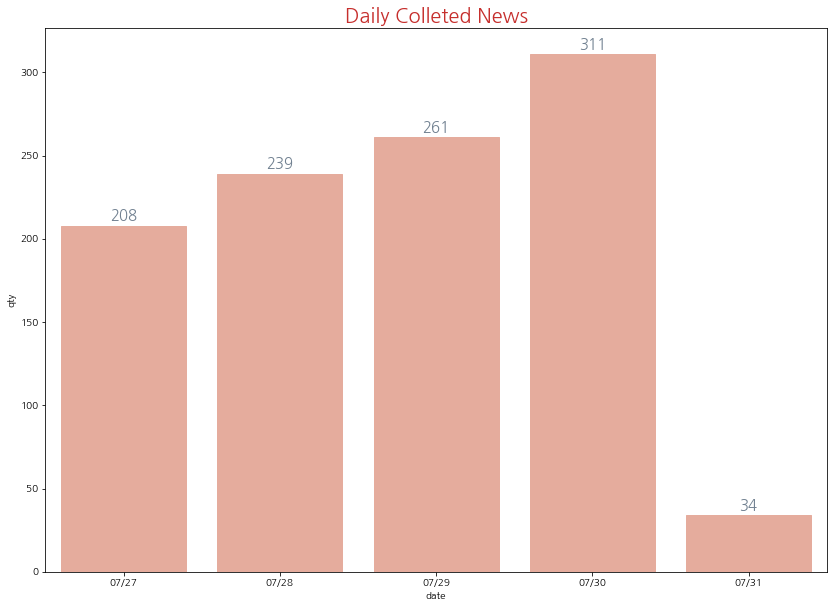

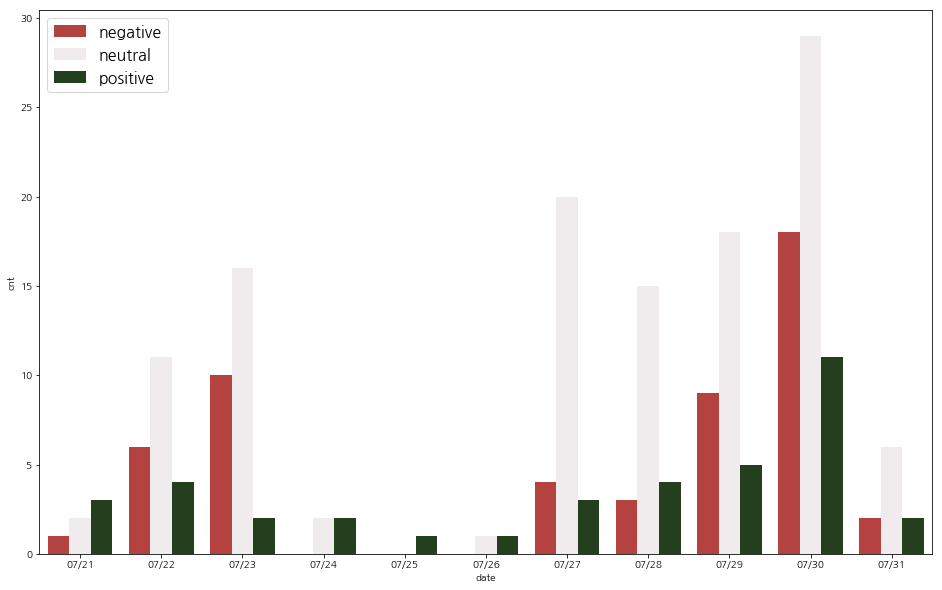

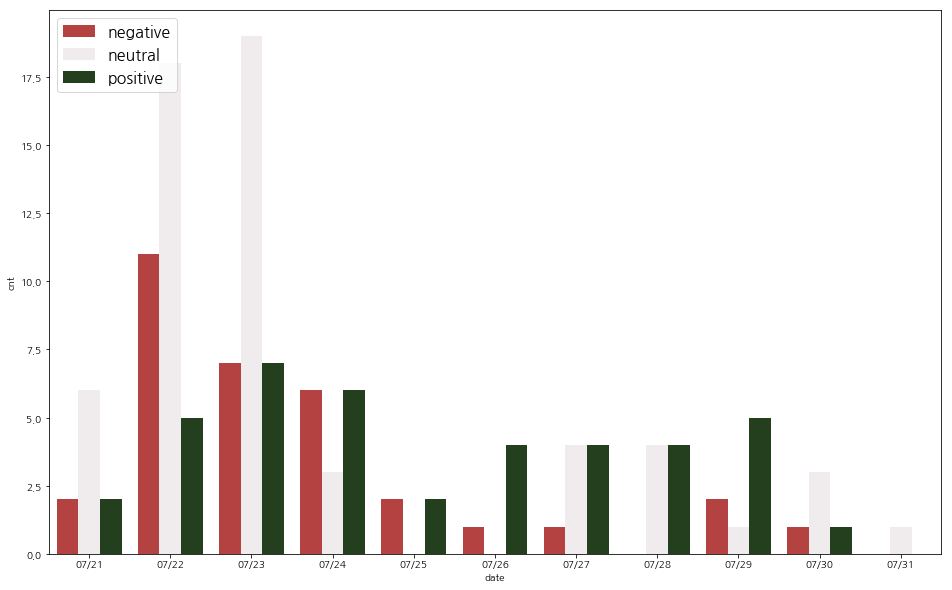

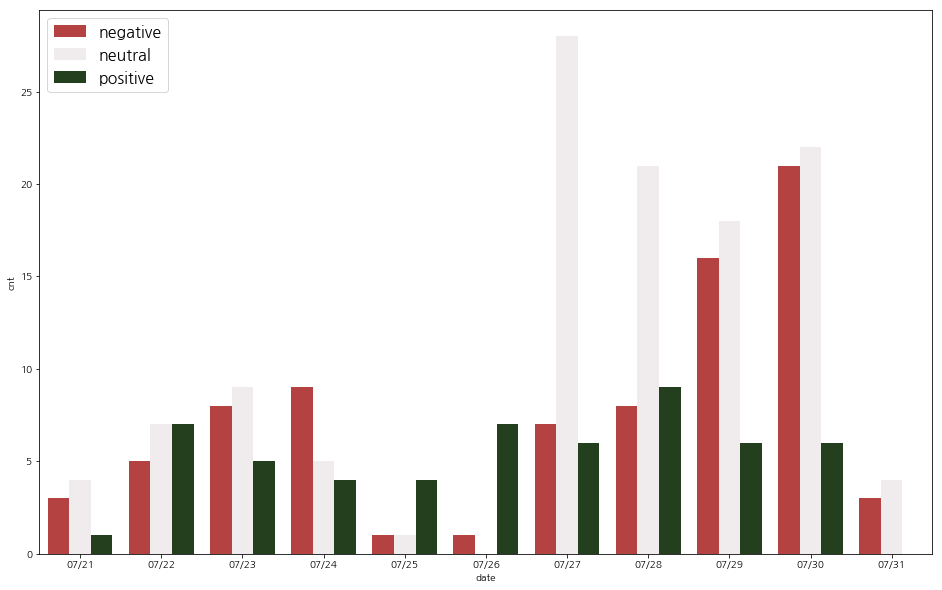

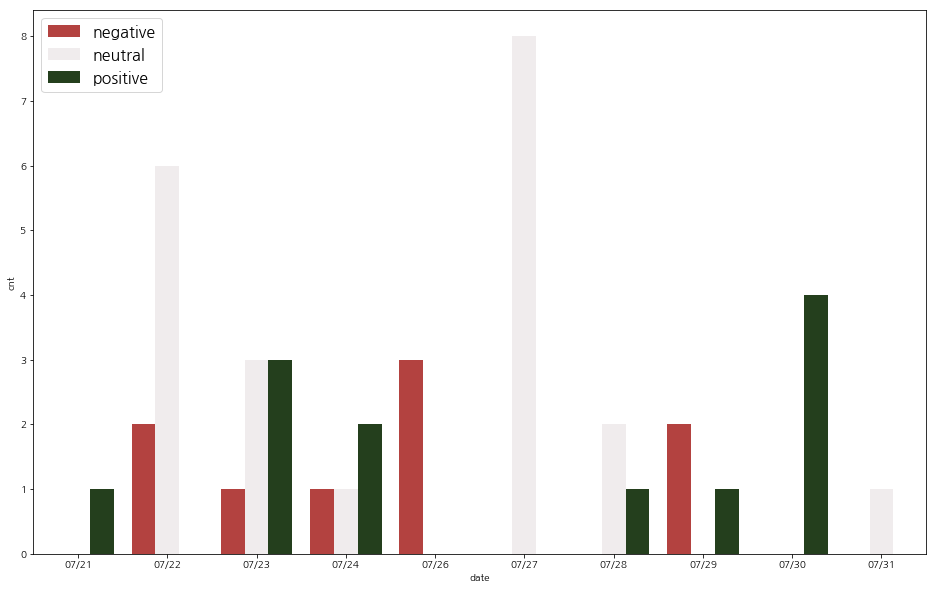

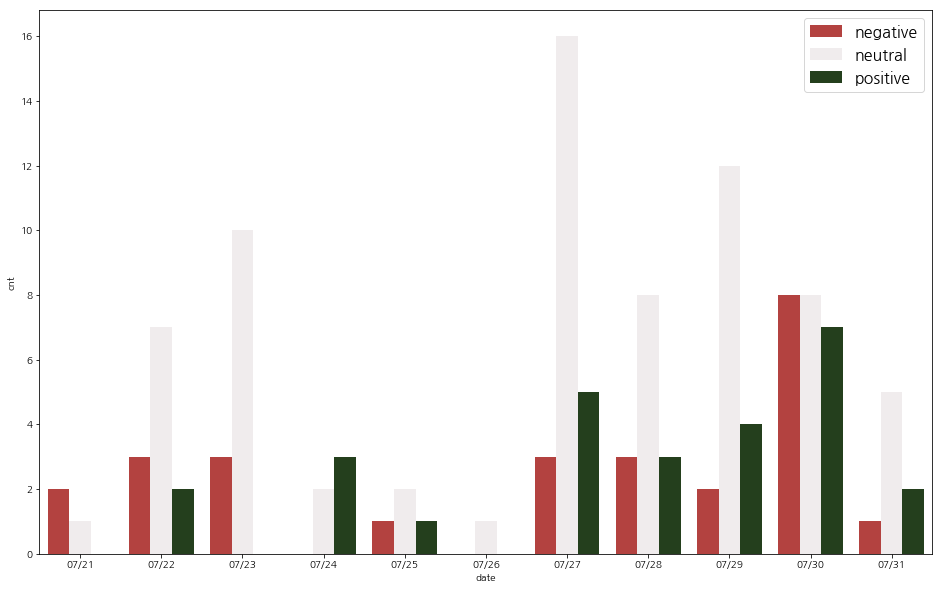

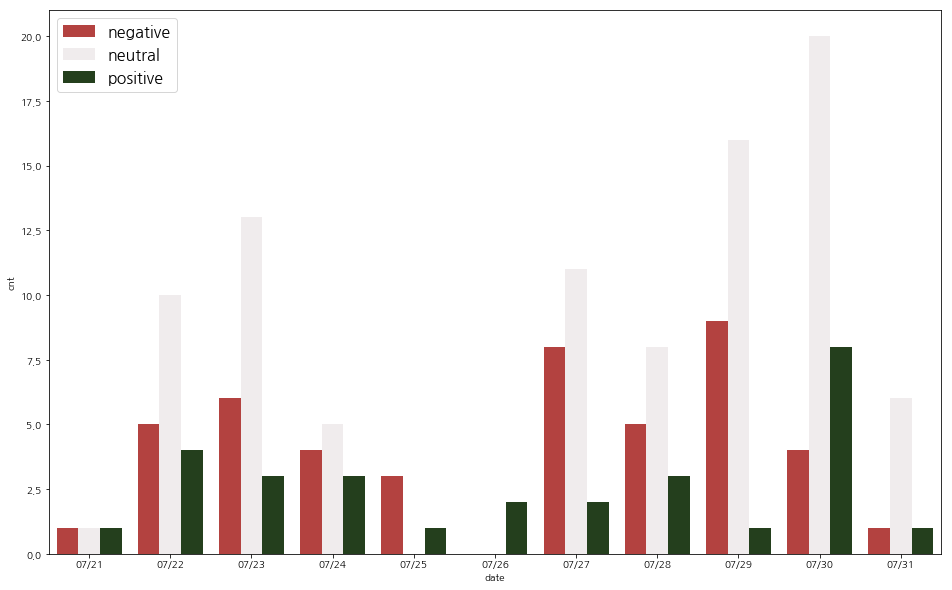

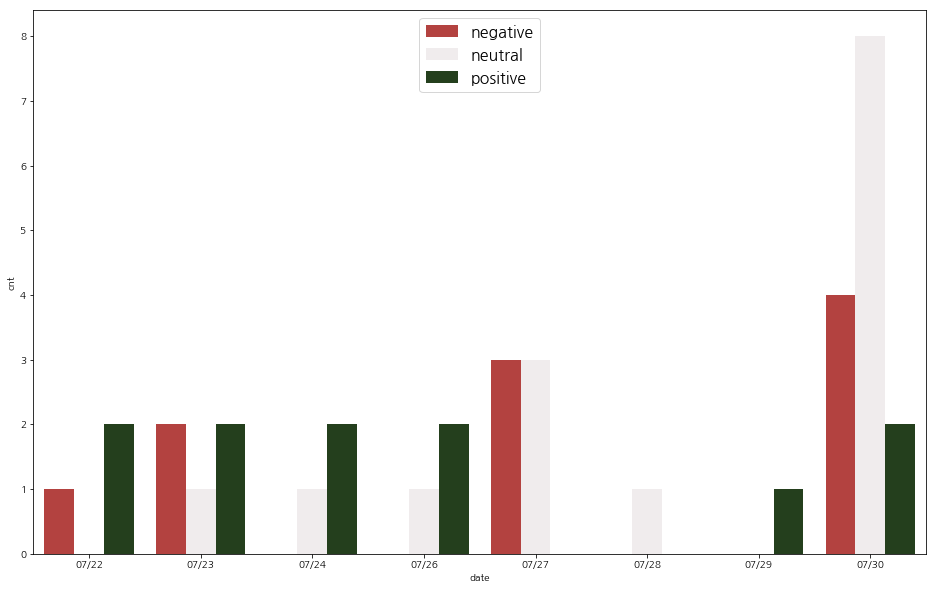

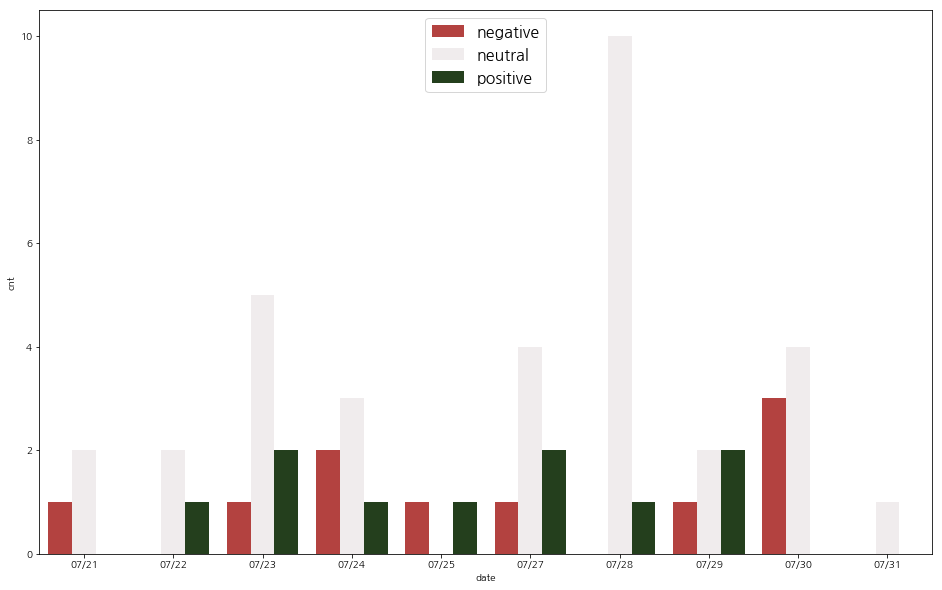

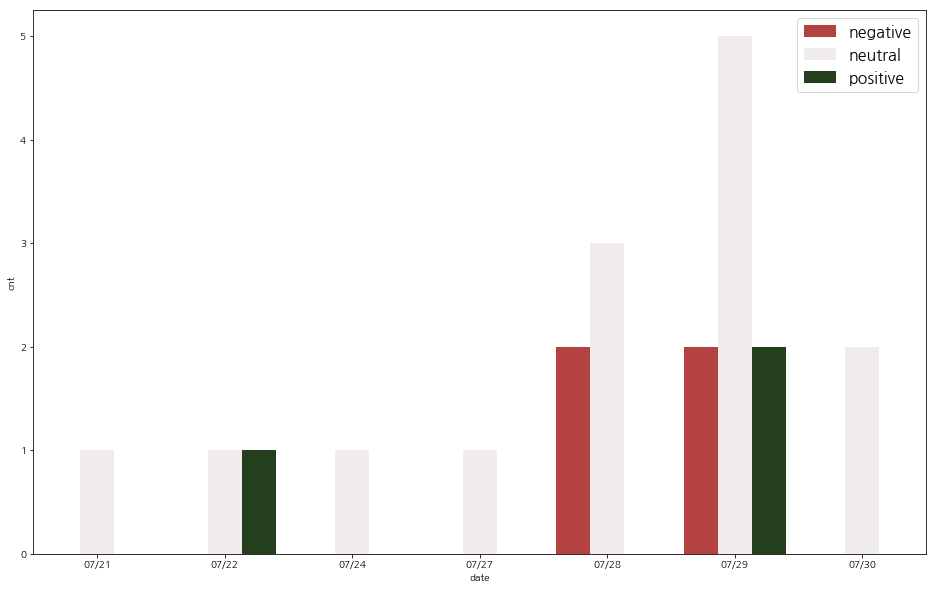

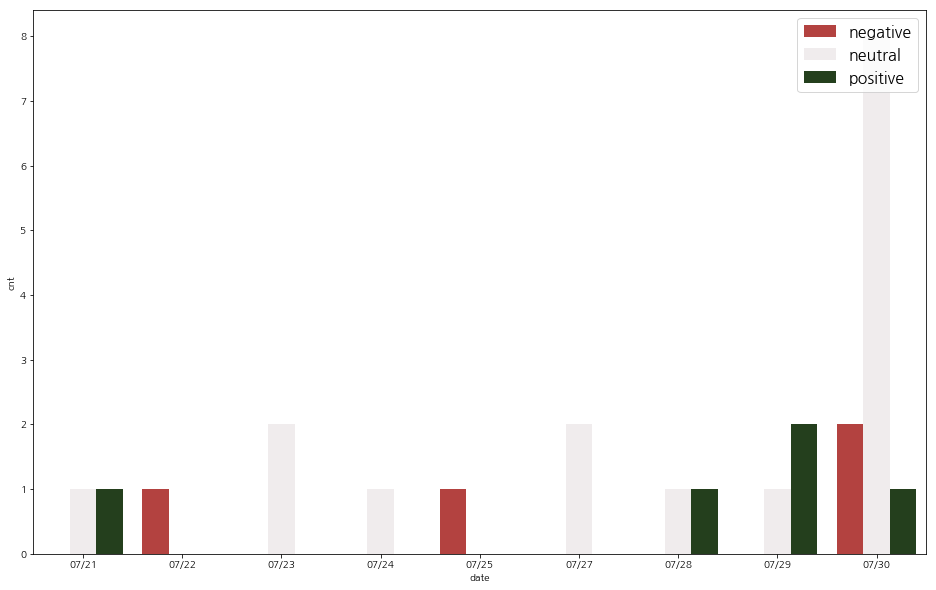

In [3]:
newcount_graph()
for stk in stock_lists:
    ss = f'select pubdate, title, url, summary,score, host from nutch_ext where {stk} is NOT NULL '

    conn = hive.Connection(host ='daou-bd-r01a01', port = 10000)
    cursor = conn.cursor()
    cursor.execute(ss)
    news_coll = cursor.fetchall()
    news_list = [{selectedcol[i] : a[i] for i in range(len(a))} for a in news_coll ]
    news_list = [{ k: datetime.datetime.strptime(v, "%Y%m%d%H%M%S") if k == 'pubdate' else v for k,v in x.items()} for x in news_list]
    news_list =  [dict(item, **{'name':stock_lists[stk]}) for item in news_list]
    news_list = sorted(news_list, key=lambda k: k['pubdate']) 
    STK = stk.upper()

    #calcualte score
    scoresss = [float(a['score']) for a in news_list]
    q1 = np.percentile(scoresss,25)
    q3 = np.percentile(scoresss,75)

    #give polarity 
    for a in news_list:
        if float(a['score']) < q1:
            a['polarity'] = 'negative'
        elif float(a['score']) > q3:
            a['polarity'] ='positive'
        else:
            a['polarity'] = "neutral"

    timeman = pd.DataFrame([a['polarity']for a in news_list],[a['pubdate'] for a in news_list]).reset_index().rename(columns={'index':'date',0:'polarity'})
    timeman = timeman[timeman['date'] >= datetime.datetime.today() - datetime.timedelta(days = 10)]

    timeman['date']=[a.strftime('%Y%m%d')[4:6]+'/'+a.strftime('%Y%m%d')[6:8] for a in timeman['date']]
    timeman =pd.DataFrame(timeman.groupby(['date','polarity']).size()).rename(columns={0:'cnt'}).reset_index()
    plt.figure(figsize=(16,10))
    plt.legend(fontsize='x-large')
    ax= sns.barplot(x="date", y="cnt",hue_order = ['negative', 'neutral', 'positive'], hue="polarity", data=timeman,palette=['#c62f2d', "#f1ebec", "#214517"])
    ax.legend(fontsize=16)

    plt.savefig(f'polarity_{STK}.png', bbox_inches='tight')
